In [1]:
import pandas as pd
import numpy as np
import re

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_74319/237007369.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Import Data

In [2]:
df = pd.read_csv('/Users/ryangeygan/Downloads/superstore.csv')

### Some Necessary Formatting

In [3]:
# Standardize date formats and convert to datetime
# Sidenote - this was sort of nasty not sure if intentional but would be nice to format this column for future test takers
def standardize_date(date_str):
    if re.match(r'\d{1,2}-\d{1,2}-\d{4}', date_str):  # Check for d-m-y format
        return pd.to_datetime(date_str, format='%d-%m-%Y')
    elif re.match(r'\d{1,2}/\d{1,2}/\d{4}', date_str):  # Check for m/d/y format
        return pd.to_datetime(date_str, format='%m/%d/%Y')
    else:
        return pd.NaT  # Return NaT for invalid dates

df['order_date'] = df['order_date'].apply(standardize_date)

### Check for Nulls

In [4]:
## No Null Values - that's nice

null_counts = {}
for column in df.columns:
    null_counts[column] = df[column].isnull().sum()

print(null_counts)

{'row_id': 0, 'order_id': 0, 'order_date': 0, 'ship_date': 0, 'ship_mode': 0, 'customer_id': 0, 'customer_name': 0, 'segment': 0, 'city': 0, 'state': 0, 'country': 0, 'postal_code': 41296, 'market': 0, 'region': 0, 'product_id': 0, 'category': 0, 'sub-category': 0, 'product_name': 0, 'sales': 0, 'quantity': 0, 'discount': 0, 'profit': 0, 'shipping_cost': 0, 'order_priority': 0}


# Question 1: Are There Regular Customers?

A histogram of the total quantity of all products purchased by each unique customer shows us that there are customers with high and low levels of purchase - you can see a bimodal distribution. But are these large quantities of purchases just large one-time orders or are they repeated over time?

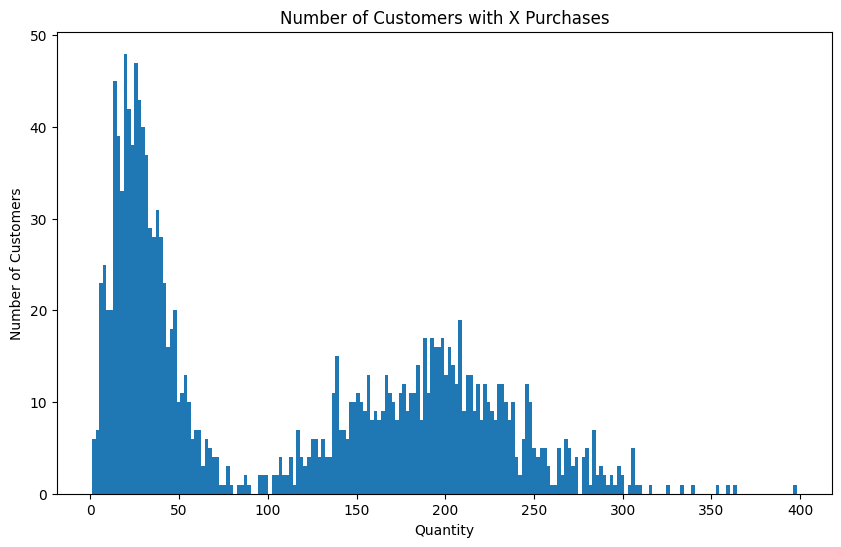

In [5]:
plt.rcParams['figure.figsize'] = (10, 6)

# Group by customer ID and sum the total quantity of items they have purchased across all their orders
purchase_quant = df.groupby('customer_id')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

purchase_quant.quantity.plot(kind='hist', bins=200)

# Adding labels and title
plt.xlabel('Quantity')
plt.ylabel('Number of Customers')
plt.title('Number of Customers with X Purchases')

# Displaying the plot
plt.show()

There also appear to be customers that have purchased items across multiple unique dates in time, implying that some customers are "regular" in the sense that they have purchased items on more than one date. Some customers have purchased items on 20 or more unique dates. For the sake of time our definition of "regular" is based on how many dates in time the customer purchased an item. There isn't time in this assessment to do anything fancy in how we calculate regularity but one idea would be to calculate the average number of days between purchases for each customer and normalize it by total number of dates. The lower the number, the more regular

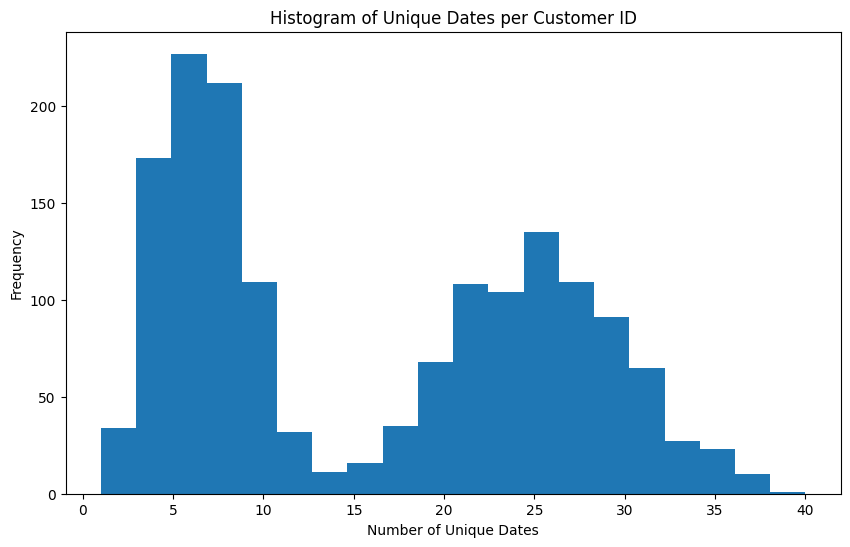

In [6]:
# Group by Customer_ID and count unique dates
date_counts = df.groupby('customer_id')['order_date'].nunique()

# Plotting the histogram using Matplotlib
plt.hist(date_counts, bins=20)  # Set bins to each unique date count
plt.xlabel('Number of Unique Dates')
plt.ylabel('Frequency')
plt.title('Histogram of Unique Dates per Customer ID')


plt.show()

To see if the regular customers are the most profitable ones, we'll compare customer "regularity" (or the total number of unique purchase dates per customer) with total purchases over time and see if there is any trend.

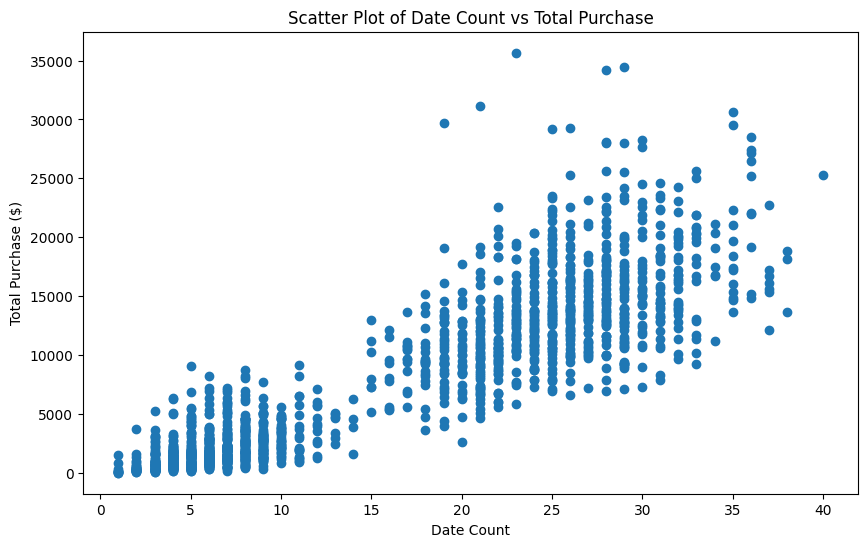

In [7]:
## Calculate the total number of unique dates (again) and the total purchase
sales_df = df.groupby('customer_id').agg(date_count=('order_date', 'nunique'), total_purchase=('sales', 'sum')).reset_index()

# Scatter plot of 'date_count' vs 'total_purchase'
plt.scatter(sales_df['date_count'], sales_df['total_purchase'])

# Adding labels and title
plt.xlabel('Date Count')
plt.ylabel('Total Purchase ($)')
plt.title('Scatter Plot of Date Count vs Total Purchase')

# Displaying the plot
plt.show()

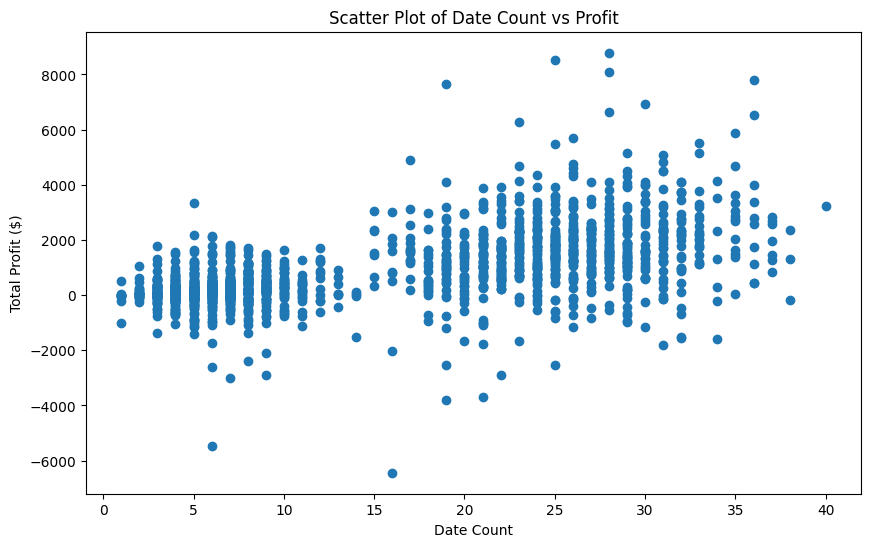

In [8]:
## Calculate the total number of unique dates (again) and the total purchase
profit_df = df.groupby('customer_id').agg(date_count=('order_date', 'nunique'), total_profit=('profit', 'sum')).reset_index()

# Scatter plot of 'date_count' vs 'total_purchase'
plt.scatter(profit_df['date_count'], profit_df['total_profit'])

# Adding labels and title
plt.xlabel('Date Count')
plt.ylabel('Total Profit ($)')
plt.title('Scatter Plot of Date Count vs Profit')

# Displaying the plot
plt.show()

We'll split the customers into two groups - fortunately there appears to be an obvious break in "regularity" around 15 days. For this assessment we'll consider two groups of customers, those that have made more than 15 seperate orders and those that have made less than 15 seperate orders. We'll use a t test to get a sense of whether the total profit is different between the groups

In [9]:
from scipy.stats import ttest_ind

# Assuming you have two groups stored in arrays or lists
group1 = list(profit_df[profit_df.date_count<=15].total_profit)
group2 = list(profit_df[profit_df.date_count>15].total_profit)

# Perform t-test
t_statistic, p_value = ttest_ind(group1, group2)

print(p_value)

1.4158064839512939e-126


The p-value is very low giving us confidence that the total profit is different between the two groups

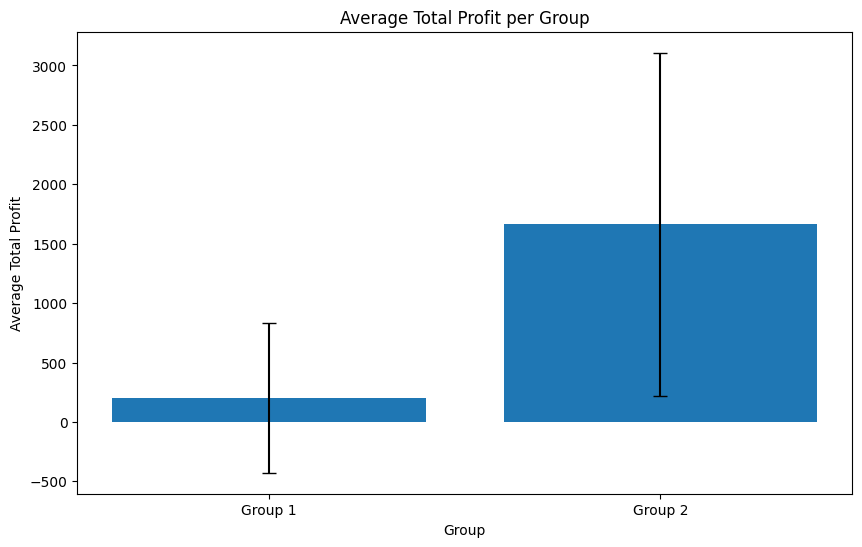

In [10]:
# Calculate mean and standard deviation for each group
mean_group1 = np.mean(group1)
std_group1 = np.std(group1)
mean_group2 = np.mean(group2)
std_group2 = np.std(group2)

# Plotting the means with error bars
plt.bar(['Group 1', 'Group 2'], [mean_group1, mean_group2], yerr=[std_group1, std_group2], capsize=5)

# Adding labels and title
plt.xlabel('Group')
plt.ylabel('Average Total Profit')
plt.title('Average Total Profit per Group')

# Displaying the plot
plt.show()

## Overall Assessment of Regular Customers

There seem to be two groups of cusomters in terms of regularity as defined here - the more regular group appears to have higher average profit

# Question 2: Which Product Sub-Categories Have the Most Negative Sales?

Looks like Tables!

In [11]:
negative_profit = df[df.profit<0]

In [12]:
negative_profit.groupby(['sub-category'])['profit'].sum().sort_values()

sub-category
Tables        -144123.14860
Bookcases     -101446.29730
Phones         -96417.66010
Chairs         -96084.89690
Machines       -78672.74030
Storage        -76063.97800
Copiers        -71547.49982
Appliances     -63991.69040
Binders        -52884.06130
Accessories    -39857.49820
Furnishings    -28514.49690
Art            -21660.62770
Supplies       -18184.43100
Envelopes      -10863.56550
Paper          -10299.49370
Fasteners       -6273.29990
Labels          -3760.77010
Name: profit, dtype: float64

# Question 3: Product Category Sales over Time

### Aggregating Data to Month

In [13]:
df['month_year'] = df['order_date'].dt.to_period('M')

# Group by month/year and category, then sum up quantity
timeseries_df = df.groupby(['month_year', 'category'], as_index=False)['sales'].sum()

# Convert 'month_year' to PeriodIndex
timeseries_df['month_year'] = pd.PeriodIndex(timeseries_df['month_year'])

# Convert 'month_year' back to DateTimeIndex
timeseries_df['month_year'] = timeseries_df['month_year'].dt.to_timestamp()

# Set 'month_year' as the date index
timeseries_df.set_index('month_year', inplace=True)

### Plot Timeseries

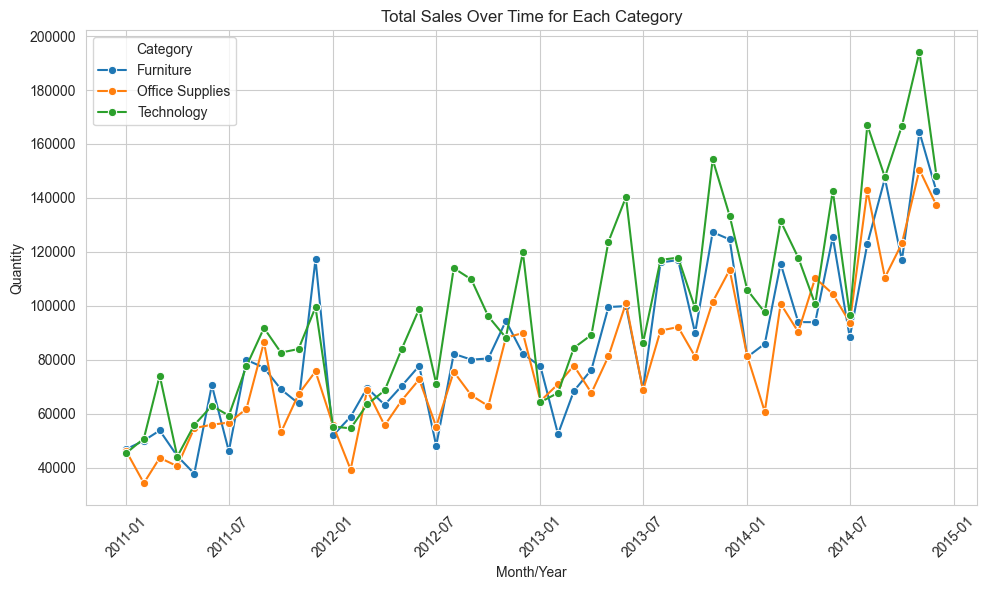

In [14]:
# Plot the quantity over time for each category using Seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=timeseries_df, x=timeseries_df.index, y='sales', hue='category', marker='o')

# Adding labels and title
plt.xlabel('Month/Year')
plt.ylabel('Quantity')
plt.title('Total Sales Over Time for Each Category')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Displaying the plot
plt.legend(title='Category', loc='upper left')
plt.tight_layout()
plt.show()

### Quick Analysis of Trend

There is a trend in total sales across each category that is increasing over time

Note: we could model the data several ways using ARMA, recurrent nueral net, etc. but the goal here wasn't to make predictions

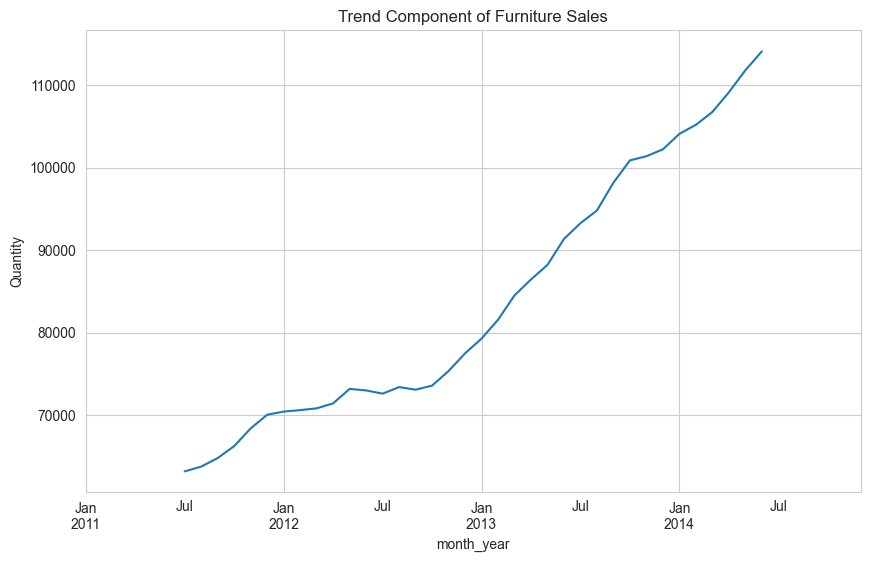

In [15]:
# Filter the data for the 'Furniture' category
furniture = timeseries_df[timeseries_df['category'] == 'Furniture'][['sales']]

# Perform seasonal decomposition
results = seasonal_decompose(furniture)

plt.rcParams['figure.figsize'] = (20, 6)

# Plot the trend component
plt.figure(figsize=(10, 6))
results.trend.plot()
plt.title('Trend Component of Furniture Sales')
plt.ylabel('Quantity')
plt.show()

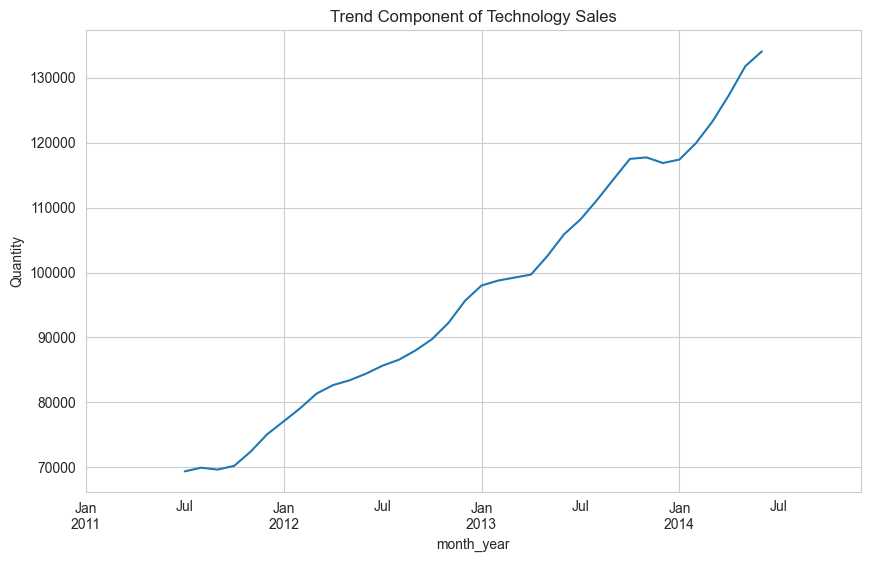

In [16]:
# Filter the data for the 'Furniture' category
furniture = timeseries_df[timeseries_df['category'] == 'Technology'][['sales']]

# Perform seasonal decomposition
results = seasonal_decompose(furniture)

plt.rcParams['figure.figsize'] = (20, 6)

# Plot the trend component
plt.figure(figsize=(10, 6))
results.trend.plot()
plt.title('Trend Component of Technology Sales')
plt.ylabel('Quantity')
plt.show()

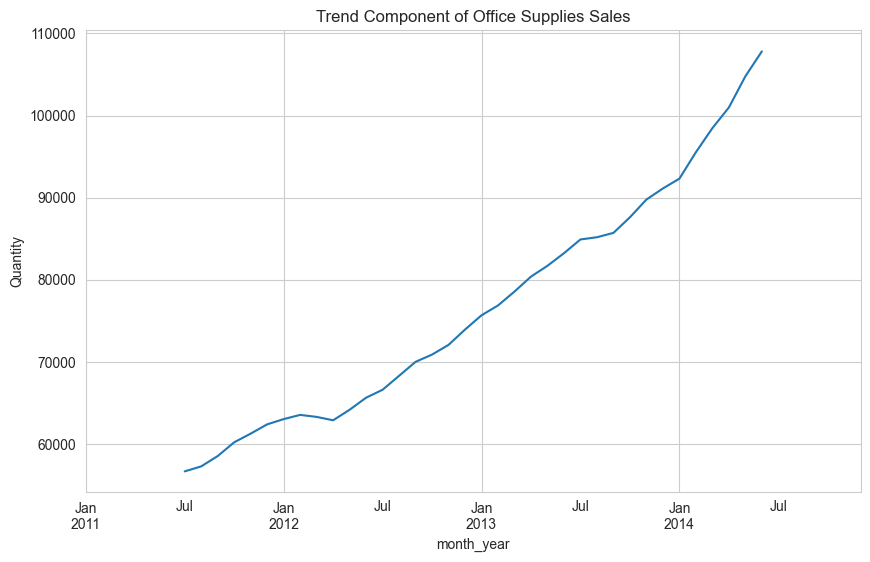

In [17]:
# Filter the data for the 'Furniture' category
furniture = timeseries_df[timeseries_df['category'] == 'Office Supplies'][['sales']]

# Perform seasonal decomposition
results = seasonal_decompose(furniture)

plt.rcParams['figure.figsize'] = (20, 6)

# Plot the trend component
plt.figure(figsize=(10, 6))
results.trend.plot()
plt.title('Trend Component of Office Supplies Sales')
plt.ylabel('Quantity')
plt.show()

# Question 4: Product Category Sales by Market

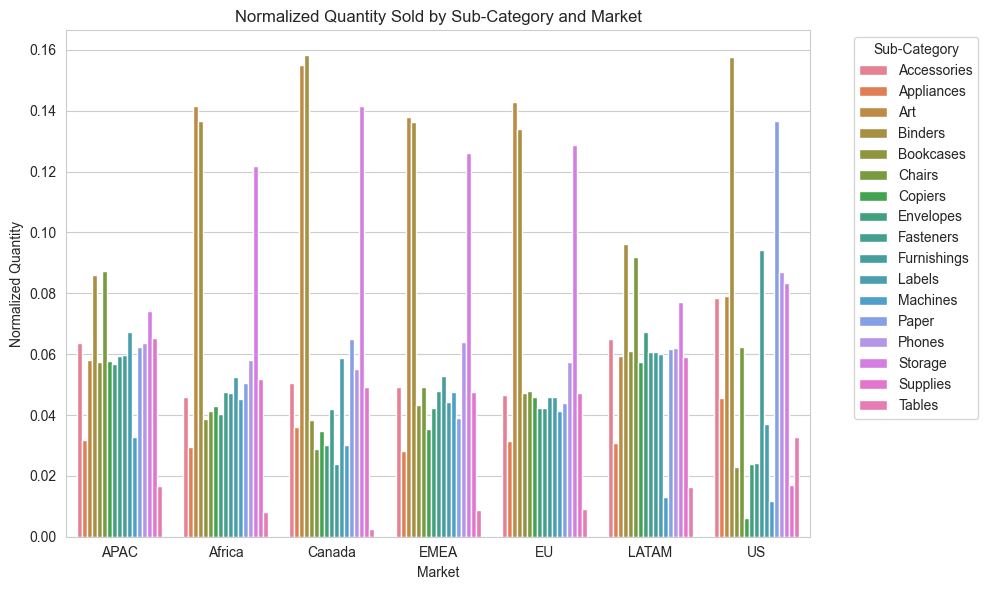

In [18]:
# Group by sub-category and market, then sum up sales
sales_by_category_market = df.groupby(['sub-category', 'market'])['quantity'].sum().reset_index()

# Calculate total quantity sold for each market
total_quantity_by_market = sales_by_category_market.groupby('market')['quantity'].transform('sum')

# Normalize the quantities by total quantity for each market
sales_by_category_market['normalized_quantity'] = sales_by_category_market['quantity'] / total_quantity_by_market

# Plot the bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_category_market, x='market', y='normalized_quantity', hue='sub-category')

# Adding labels and title
plt.xlabel('Market')
plt.ylabel('Normalized Quantity')
plt.title('Normalized Quantity Sold by Sub-Category and Market')

# Displaying the plot
plt.legend(title='Sub-Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()
plt.show()

## Overall Assessment

There appears to be a similar trend to the total quantity of each sub-category that is purchased in each market. In other words, although there are absolute differences in total quantity purchased for each sub-category in each market, the same sub-categories appear to be performing similarly. For example, sales of "Art" and "Binders" are often the most purchased items across each market along with "Storage" items. The purchase of "Paper" and "Furnishings" appear to be higher in the US relative to the other markets while in LATAM and APAC the sales of "Copiers", "Envenlopes", and "Fasteners" is relatively higher